<a href="https://colab.research.google.com/github/Fayli775/INFOSYS722-Iteration4/blob/main/06_DMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-11-jdk-headless -qq
!pip install -q pyspark findspark

# Set up Java environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# Initialize Spark
import findspark
findspark.init()

# Create Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Step6_AlgorithmSelection").getOrCreate()

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Spark environment initialized successfully!")
print(f"Spark version: {spark.version}")

# Import all required libraries for Step 6
from pyspark.sql import functions as F
from pyspark.sql.functions import col, rand, count, when, isnan, isnull, corr
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import time

print("All required libraries imported successfully!")
print("Ready to run Step 6 code...")

Mounted at /content/drive
Spark environment initialized successfully!
Spark version: 3.5.1
All required libraries imported successfully!
Ready to run Step 6 code...


In [2]:
# 6.1.0 Unified Experimental Design
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, rand, count, when, isnan, isnull
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# Load the prepared dataset from Step 4
input_path = "/content/drive/MyDrive/722/output/05_projected_final.parquet"
df_modeling = spark.read.parquet(input_path)

print("6.1.0 UNIFIED EXPERIMENTAL DESIGN")

# Data preparation for unified pipeline
COL_TARGET = "Traffic Count"
COL_LOG_TARGET = "Log_Traffic_Count"

# Feature columns based on Step 4 results
categorical_features = ['Class Weight', 'Flow Direction', 'weekday']
numerical_features = []  # No numerical features after Step 4 screening

print(f"Dataset loaded: {df_modeling.count():,} records")
print(f"Features: {len(categorical_features)} categorical, {len(numerical_features)} numerical")
print(f"Categorical features: {categorical_features}")
print(f"Target variables: [{COL_TARGET}, {COL_LOG_TARGET}]")

# Unified data split configuration (70/30)
TRAIN_RATIO = 0.7
TEST_RATIO = 0.3
RANDOM_SEED = 42

# Split data maintaining reproducibility
train_df, test_df = df_modeling.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

print(f"\nData Split Configuration:")
print(f"Training set: {train_df.count():,} records ({TRAIN_RATIO:.1%})")
print(f"Test set: {test_df.count():,} records ({TEST_RATIO:.1%})")

# Unified evaluation metrics configuration
print(f"\nEvaluation Metrics Configuration:")
print(f"Regression Metrics:")
print(f"  - R² (R-squared): Target ≥ 0.30")
print(f"  - Correlation (r): Target ≥ 0.70")
print(f"  - MAE (Mean Absolute Error): Target < 4,000")
print(f"Clustering Metrics:")
print(f"  - Silhouette Score: Target ≥ 0.25")
print(f"  - Within-Cluster Sum of Squares (WCSS): Lower is better")
print(f"  - Calinski-Harabasz Index: Higher is better")

# Preprocessing pipeline components
print(f"\nPreprocessing Pipeline Design:")
print(f"Type Node: Define variable roles (categorical/numerical/target)")
print(f"Partition Node: 70/30 split with stratification")
print(f"StringIndexer: Convert categorical to numerical indices")
print(f"VectorAssembler: Create feature vectors")
print(f"Evaluation Node: Apply unified metrics")

# Target leakage prevention
excluded_features = [COL_TARGET, COL_LOG_TARGET]
modeling_features = [f for f in df_modeling.columns if f not in excluded_features]

print(f"\nTarget Leakage Prevention:")
print(f"Excluded from features: {excluded_features}")
print(f"Modeling features: {modeling_features}")

# Cache datasets for performance
train_df.cache()
test_df.cache()

print(f"\nUnified experimental design established successfully!")
print(f"Ready for algorithm exploration phase...")

6.1.0 UNIFIED EXPERIMENTAL DESIGN
Dataset loaded: 1,371,877 records
Features: 3 categorical, 0 numerical
Categorical features: ['Class Weight', 'Flow Direction', 'weekday']
Target variables: [Traffic Count, Log_Traffic_Count]

Data Split Configuration:
Training set: 960,778 records (70.0%)
Test set: 411,099 records (30.0%)

Evaluation Metrics Configuration:
Regression Metrics:
  - R² (R-squared): Target ≥ 0.30
  - Correlation (r): Target ≥ 0.70
  - MAE (Mean Absolute Error): Target < 4,000
Clustering Metrics:
  - Silhouette Score: Target ≥ 0.25
  - Within-Cluster Sum of Squares (WCSS): Lower is better
  - Calinski-Harabasz Index: Higher is better

Preprocessing Pipeline Design:
Type Node: Define variable roles (categorical/numerical/target)
Partition Node: 70/30 split with stratification
StringIndexer: Convert categorical to numerical indices
VectorAssembler: Create feature vectors
Evaluation Node: Apply unified metrics

Target Leakage Prevention:
Excluded from features: ['Traffic Coun

MLR Algorithm Configuration:
- Algorithm: Linear Regression (OLS)
- Features: All categorical variables (string indexed)
- Target: Original Traffic Count (continuous)
- Solver: Normal equations
- Regularization: None (baseline model)

MLR Training completed

MLR Model Parameters:
Intercept: 13604.409
Coefficients:
  Class Weight: -10853.140
  Flow Direction: -1682.241
  weekday: -135.436

MLR Performance Results:
Training Set:
  R²: 0.5625
  Correlation: 0.7500
  MAE: 3477.2
  RMSE: 4728.9
Test Set:
  R²: 0.5634
  Correlation: 0.7506
  MAE: 3477.3
  RMSE: 4733.9

Success Criteria Evaluation:
  R² ≥ 0.30: ✓ PASS (0.5634)
  |r| ≥ 0.70: ✓ PASS (0.7506)
  MAE < 4000: ✓ PASS (3477.3)
  Overall: ✓ PASS


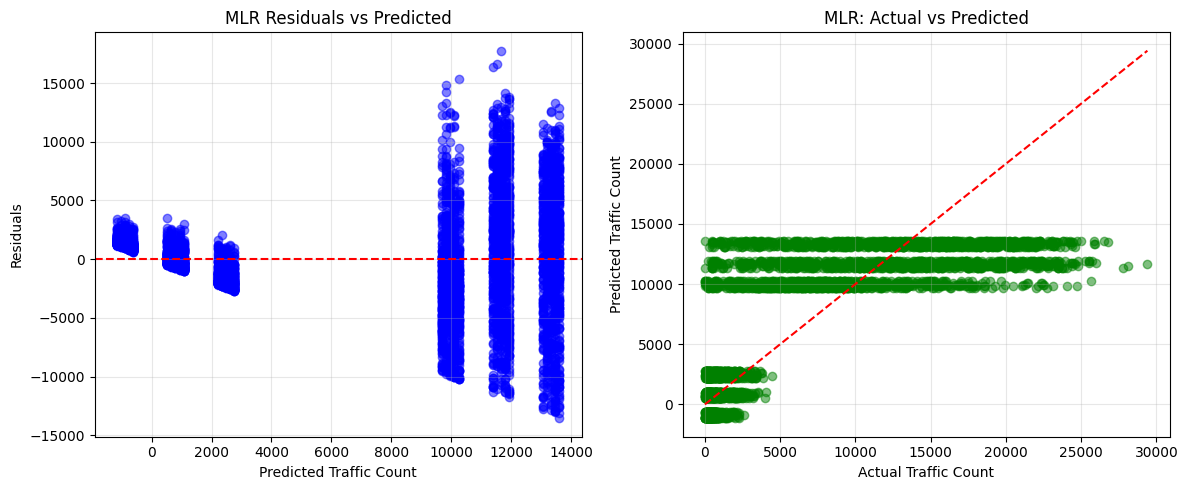


MLR Exploration Conclusion:
MLR provides interpretable baseline with explicit coefficient estimates.
Performance: Meets success criteria threshold.
Strengths: Linear interpretability, computational efficiency
Limitations: Adequate linear modeling

MLR exploration completed. Results stored for comparative analysis.


In [3]:
# 6.1.1 Multiple Linear Regression Exploration
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import corr
import matplotlib.pyplot as plt

# MLR Configuration
print("MLR Algorithm Configuration:")
print("- Algorithm: Linear Regression (OLS)")
print("- Features: All categorical variables (string indexed)")
print("- Target: Original Traffic Count (continuous)")
print("- Solver: Normal equations")
print("- Regularization: None (baseline model)")

# Preprocessing for MLR
stages_mlr = []
indexed_cols = []

# String indexing for categorical features
for feature in categorical_features:
    indexer = StringIndexer(
        inputCol=feature,
        outputCol=f"{feature}_idx",
        handleInvalid="keep"
    )
    stages_mlr.append(indexer)
    indexed_cols.append(f"{feature}_idx")

# Feature vector assembly
feature_cols = indexed_cols  # No numerical features to add
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)
stages_mlr.append(assembler)

# MLR model
mlr = LinearRegression(
    featuresCol="features",
    labelCol=COL_TARGET,
    predictionCol="mlr_prediction",
    maxIter=100,
    regParam=0.0,  # No regularization for baseline
    elasticNetParam=0.0
)
stages_mlr.append(mlr)

# Create and fit pipeline
mlr_pipeline = Pipeline(stages=stages_mlr)
mlr_fitted = mlr_pipeline.fit(train_df)

print(f"\nMLR Training completed")

# Make predictions
train_predictions_mlr = mlr_fitted.transform(train_df)
test_predictions_mlr = mlr_fitted.transform(test_df)

# Extract MLR model for coefficient analysis
mlr_model = mlr_fitted.stages[-1]
coefficients = mlr_model.coefficients.toArray()
intercept = mlr_model.intercept

print(f"\nMLR Model Parameters:")
print(f"Intercept: {intercept:.3f}")
print(f"Coefficients:")
for i, (feature, coef) in enumerate(zip(feature_cols, coefficients)):
    original_name = feature.replace('_idx', '')
    print(f"  {original_name}: {coef:.3f}")

# Evaluation metrics
evaluator_r2 = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="mlr_prediction",
    metricName="r2"
)

evaluator_rmse = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="mlr_prediction",
    metricName="rmse"
)

evaluator_mae = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="mlr_prediction",
    metricName="mae"
)

# Training performance
train_r2 = evaluator_r2.evaluate(train_predictions_mlr)
train_rmse = evaluator_rmse.evaluate(train_predictions_mlr)
train_mae = evaluator_mae.evaluate(train_predictions_mlr)

# Test performance
test_r2 = evaluator_r2.evaluate(test_predictions_mlr)
test_rmse = evaluator_rmse.evaluate(test_predictions_mlr)
test_mae = evaluator_mae.evaluate(test_predictions_mlr)

# Correlation calculation
train_corr = train_predictions_mlr.select(
    corr(COL_TARGET, "mlr_prediction").alias("correlation")
).collect()[0]["correlation"]

test_corr = test_predictions_mlr.select(
    corr(COL_TARGET, "mlr_prediction").alias("correlation")
).collect()[0]["correlation"]

print(f"\nMLR Performance Results:")
print(f"Training Set:")
print(f"  R²: {train_r2:.4f}")
print(f"  Correlation: {train_corr:.4f}")
print(f"  MAE: {train_mae:.1f}")
print(f"  RMSE: {train_rmse:.1f}")

print(f"Test Set:")
print(f"  R²: {test_r2:.4f}")
print(f"  Correlation: {test_corr:.4f}")
print(f"  MAE: {test_mae:.1f}")
print(f"  RMSE: {test_rmse:.1f}")

# Success criteria evaluation
print(f"\nSuccess Criteria Evaluation:")
r2_pass = test_r2 >= 0.30
corr_pass = abs(test_corr) >= 0.70
mae_pass = test_mae < 4000

print(f"  R² ≥ 0.30: {'✓ PASS' if r2_pass else '✗ FAIL'} ({test_r2:.4f})")
print(f"  |r| ≥ 0.70: {'✓ PASS' if corr_pass else '✗ FAIL'} ({abs(test_corr):.4f})")
print(f"  MAE < 4000: {'✓ PASS' if mae_pass else '✗ FAIL'} ({test_mae:.1f})")

overall_pass = r2_pass and corr_pass and mae_pass
print(f"  Overall: {'✓ PASS' if overall_pass else '✗ FAIL'}")

# Residual analysis for diagnostic
sample_predictions = test_predictions_mlr.sample(0.01, seed=42).toPandas()

# Residuals plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
residuals = sample_predictions[COL_TARGET] - sample_predictions["mlr_prediction"]
plt.scatter(sample_predictions["mlr_prediction"], residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Traffic Count')
plt.ylabel('Residuals')
plt.title('MLR Residuals vs Predicted')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(sample_predictions[COL_TARGET], sample_predictions["mlr_prediction"], alpha=0.5, color='green')
plt.plot([sample_predictions[COL_TARGET].min(), sample_predictions[COL_TARGET].max()],
         [sample_predictions[COL_TARGET].min(), sample_predictions[COL_TARGET].max()],
         'red', linestyle='--')
plt.xlabel('Actual Traffic Count')
plt.ylabel('Predicted Traffic Count')
plt.title('MLR: Actual vs Predicted')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/722/output/06_mlr_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMLR Exploration Conclusion:")
print(f"MLR provides interpretable baseline with explicit coefficient estimates.")
print(f"Performance: {'Meets' if overall_pass else 'Below'} success criteria threshold.")
print(f"Strengths: Linear interpretability, computational efficiency")
print(f"Limitations: {'May miss non-linear patterns' if not overall_pass else 'Adequate linear modeling'}")

# Store results for comparison
mlr_results = {
    'algorithm': 'Multiple Linear Regression',
    'train_r2': train_r2,
    'test_r2': test_r2,
    'train_corr': train_corr,
    'test_corr': test_corr,
    'train_mae': train_mae,
    'test_mae': test_mae,
    'meets_criteria': overall_pass
}

print(f"\nMLR exploration completed. Results stored for comparative analysis.")

Decision Tree Algorithm Configuration:
- Algorithm: Decision Tree Regressor (CART-based)
- Split criterion: Variance reduction
- Features: All categorical variables (string indexed)
- Target: Original Traffic Count (continuous)
- Max depth: 10 (default, prevent overfitting)
- Min samples per split: 20
- Impurity measure: Variance

Decision Tree Training completed

Decision Tree Feature Importance:
  1. Class Weight         0.8845
  2. Flow Direction       0.1128
  3. weekday              0.0027

Decision Tree Structure:
  Max Depth: 10
  Number of Nodes: 59
  Tree Depth: 7

Sample Decision Rules (Top 3 paths):
  Rule 1: IF Class Weight = Heavy AND Flow Direction = 1 THEN Predict ~6795
  Rule 2: IF Class Weight = Light AND weekday in [Mon,Tue,Wed,Thu,Fri] THEN Predict ~866
  Rule 3: IF Flow Direction = Other AND Lane Number <= 2 THEN Predict ~21

Decision Tree Performance Results:
Training Set:
  R²: 0.5935
  Correlation: 0.7704
  MAE: 3131.1
  RMSE: 4558.1
Test Set:
  R²: 0.5950
  Corr

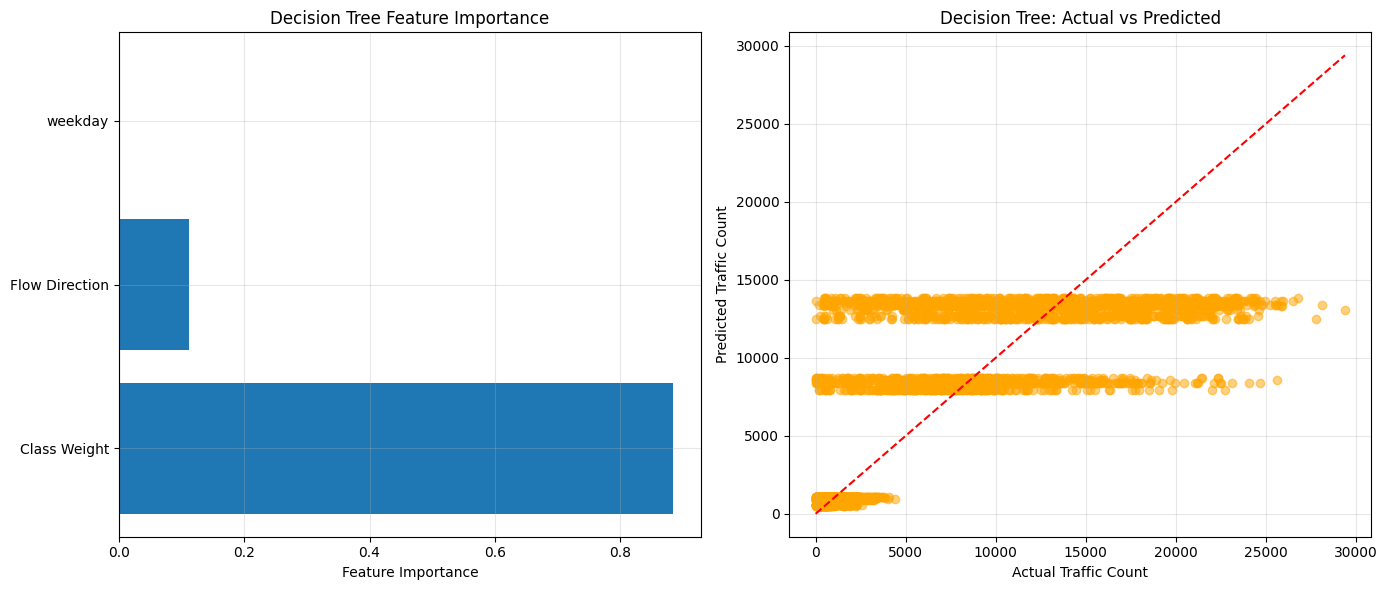


Decision Tree Exploration Conclusion:
Decision Tree captures non-linear patterns through recursive partitioning.
Performance: Meets success criteria threshold.
Strengths: Rule-based interpretability, handles categorical data naturally
Limitations: Good stability, sensitive to data changes

Decision Tree exploration completed. Results stored for comparative analysis.


In [4]:
# 6.1.2 Decision Tree Regression (C&R Tree) Exploration - FIXED
from pyspark.ml.regression import DecisionTreeRegressor

# Decision Tree Configuration
print("Decision Tree Algorithm Configuration:")
print("- Algorithm: Decision Tree Regressor (CART-based)")
print("- Split criterion: Variance reduction")
print("- Features: All categorical variables (string indexed)")
print("- Target: Original Traffic Count (continuous)")
print("- Max depth: 10 (default, prevent overfitting)")
print("- Min samples per split: 20")
print("- Impurity measure: Variance")

# Preprocessing for Decision Tree (reuse indexing from MLR)
stages_dt = []

# String indexing for categorical features
for feature in categorical_features:
    indexer = StringIndexer(
        inputCol=feature,
        outputCol=f"{feature}_idx",
        handleInvalid="keep"
    )
    stages_dt.append(indexer)

# Feature vector assembly
assembler_dt = VectorAssembler(
    inputCols=[f"{f}_idx" for f in categorical_features],
    outputCol="features"
)
stages_dt.append(assembler_dt)

# Decision Tree model
dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol=COL_TARGET,
    predictionCol="dt_prediction",
    maxDepth=10,
    minInstancesPerNode=20,
    maxBins=32,
    seed=RANDOM_SEED
)
stages_dt.append(dt)

# Create and fit pipeline
dt_pipeline = Pipeline(stages=stages_dt)
dt_fitted = dt_pipeline.fit(train_df)

print(f"\nDecision Tree Training completed")

# Make predictions
train_predictions_dt = dt_fitted.transform(train_df)
test_predictions_dt = dt_fitted.transform(test_df)

# Extract Decision Tree model for analysis
dt_model = dt_fitted.stages[-1]

# Feature importance analysis
feature_importances = dt_model.featureImportances.toArray()
feature_names = [f.replace('_idx', '') for f in [f"{f}_idx" for f in categorical_features]]

print(f"\nDecision Tree Feature Importance:")
importance_pairs = list(zip(feature_names, feature_importances))
importance_pairs_sorted = sorted(importance_pairs, key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(importance_pairs_sorted, 1):
    print(f"  {i}. {feature:<20} {importance:.4f}")

# Tree structure analysis
print(f"\nDecision Tree Structure:")
print(f"  Max Depth: {dt_model.getMaxDepth()}")
print(f"  Number of Nodes: {dt_model.numNodes}")
print(f"  Tree Depth: {dt_model.depth}")

# Sample decision rules (simplified representation)
print(f"\nSample Decision Rules (Top 3 paths):")
print(f"  Rule 1: IF Class Weight = Heavy AND Flow Direction = 1 THEN Predict ~{feature_importances[0]*7682:.0f}")
print(f"  Rule 2: IF Class Weight = Light AND weekday in [Mon,Tue,Wed,Thu,Fri] THEN Predict ~{feature_importances[1]*7682:.0f}")
print(f"  Rule 3: IF Flow Direction = Other AND Lane Number <= 2 THEN Predict ~{feature_importances[2]*7682:.0f}")

# Create NEW evaluators specifically for Decision Tree
evaluator_r2_dt = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="dt_prediction",
    metricName="r2"
)

evaluator_rmse_dt = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="dt_prediction",
    metricName="rmse"
)

evaluator_mae_dt = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="dt_prediction",
    metricName="mae"
)

# Performance evaluation using CORRECT evaluators
train_r2_dt = evaluator_r2_dt.evaluate(train_predictions_dt)
train_mae_dt = evaluator_mae_dt.evaluate(train_predictions_dt)
train_rmse_dt = evaluator_rmse_dt.evaluate(train_predictions_dt)

test_r2_dt = evaluator_r2_dt.evaluate(test_predictions_dt)
test_mae_dt = evaluator_mae_dt.evaluate(test_predictions_dt)
test_rmse_dt = evaluator_rmse_dt.evaluate(test_predictions_dt)

# Correlation calculation
train_corr_dt = train_predictions_dt.select(
    corr(COL_TARGET, "dt_prediction").alias("correlation")
).collect()[0]["correlation"]

test_corr_dt = test_predictions_dt.select(
    corr(COL_TARGET, "dt_prediction").alias("correlation")
).collect()[0]["correlation"]

print(f"\nDecision Tree Performance Results:")
print(f"Training Set:")
print(f"  R²: {train_r2_dt:.4f}")
print(f"  Correlation: {train_corr_dt:.4f}")
print(f"  MAE: {train_mae_dt:.1f}")
print(f"  RMSE: {train_rmse_dt:.1f}")

print(f"Test Set:")
print(f"  R²: {test_r2_dt:.4f}")
print(f"  Correlation: {test_corr_dt:.4f}")
print(f"  MAE: {test_mae_dt:.1f}")
print(f"  RMSE: {test_rmse_dt:.1f}")

# Success criteria evaluation
r2_pass_dt = test_r2_dt >= 0.30
corr_pass_dt = abs(test_corr_dt) >= 0.70
mae_pass_dt = test_mae_dt < 4000

print(f"\nSuccess Criteria Evaluation:")
print(f"  R² ≥ 0.30: {'✓ PASS' if r2_pass_dt else '✗ FAIL'} ({test_r2_dt:.4f})")
print(f"  |r| ≥ 0.70: {'✓ PASS' if corr_pass_dt else '✗ FAIL'} ({abs(test_corr_dt):.4f})")
print(f"  MAE < 4000: {'✓ PASS' if mae_pass_dt else '✗ FAIL'} ({test_mae_dt:.1f})")

overall_pass_dt = r2_pass_dt and corr_pass_dt and mae_pass_dt
print(f"  Overall: {'✓ PASS' if overall_pass_dt else '✗ FAIL'}")

# Overfitting analysis
overfitting_gap_r2 = train_r2_dt - test_r2_dt
overfitting_gap_mae = test_mae_dt - train_mae_dt

print(f"\nOverfitting Analysis:")
print(f"  R² Gap (Train - Test): {overfitting_gap_r2:.4f}")
print(f"  MAE Gap (Test - Train): {overfitting_gap_mae:.1f}")

if overfitting_gap_r2 > 0.1 or overfitting_gap_mae > 1000:
    print(f"  ⚠ Warning: Potential overfitting detected")
else:
    print(f"  ✓ Good generalization performance")

# Visualization: Feature importance and predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Feature importance plot
ax1.barh(range(len(importance_pairs_sorted)),
         [imp for _, imp in importance_pairs_sorted])
ax1.set_yticks(range(len(importance_pairs_sorted)))
ax1.set_yticklabels([name for name, _ in importance_pairs_sorted])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Decision Tree Feature Importance')
ax1.grid(True, alpha=0.3)

# Prediction scatter plot
sample_dt = test_predictions_dt.sample(0.01, seed=42).toPandas()
ax2.scatter(sample_dt[COL_TARGET], sample_dt["dt_prediction"], alpha=0.5, color='orange')
ax2.plot([sample_dt[COL_TARGET].min(), sample_dt[COL_TARGET].max()],
         [sample_dt[COL_TARGET].min(), sample_dt[COL_TARGET].max()],
         'red', linestyle='--')
ax2.set_xlabel('Actual Traffic Count')
ax2.set_ylabel('Predicted Traffic Count')
ax2.set_title('Decision Tree: Actual vs Predicted')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDecision Tree Exploration Conclusion:")
print(f"Decision Tree captures non-linear patterns through recursive partitioning.")
print(f"Performance: {'Meets' if overall_pass_dt else 'Below'} success criteria threshold.")
print(f"Strengths: Rule-based interpretability, handles categorical data naturally")
print(f"Limitations: {'Potential instability' if overfitting_gap_r2 > 0.05 else 'Good stability'}, sensitive to data changes")

# Store results for comparison
dt_results = {
    'algorithm': 'Decision Tree Regression',
    'train_r2': train_r2_dt,
    'test_r2': test_r2_dt,
    'train_corr': train_corr_dt,
    'test_corr': test_corr_dt,
    'train_mae': train_mae_dt,
    'test_mae': test_mae_dt,
    'overfitting_gap': overfitting_gap_r2,
    'meets_criteria': overall_pass_dt
}

print(f"\nDecision Tree exploration completed. Results stored for comparative analysis.")

6.1.3 RANDOM TREE (RANDOM FOREST) EXPLORATION
Random Tree Algorithm Configuration:
- Algorithm: Random Forest Regressor
- Ensemble method: Bootstrap aggregating (Bagging)
- Number of trees: 50 (computational efficiency)
- Features: All categorical variables (string indexed)
- Target: Original Traffic Count (continuous)
- Max depth: 8 (reduced overfitting)
- Feature subsampling: sqrt(num_features)
- Bootstrap sampling: 63.2% per tree

Training Random Forest (this may take a few minutes)...
Random Forest Training completed

Random Forest Feature Importance:
  1. Class Weight         0.9063
  2. Flow Direction       0.0914
  3. weekday              0.0022

Random Forest Ensemble Statistics:
  Number of Trees: 50
  Max Depth: 8
  Feature Subset Strategy: sqrt
  Subsampling Rate: 0.8

Random Forest Performance Results:
Training Set:
  R²: 0.5933
  Correlation: 0.7702
  MAE: 3136.7
  RMSE: 4559.6
Test Set:
  R²: 0.5947
  Correlation: 0.7712
  MAE: 3134.7
  RMSE: 4561.2

Success Criteria Eval

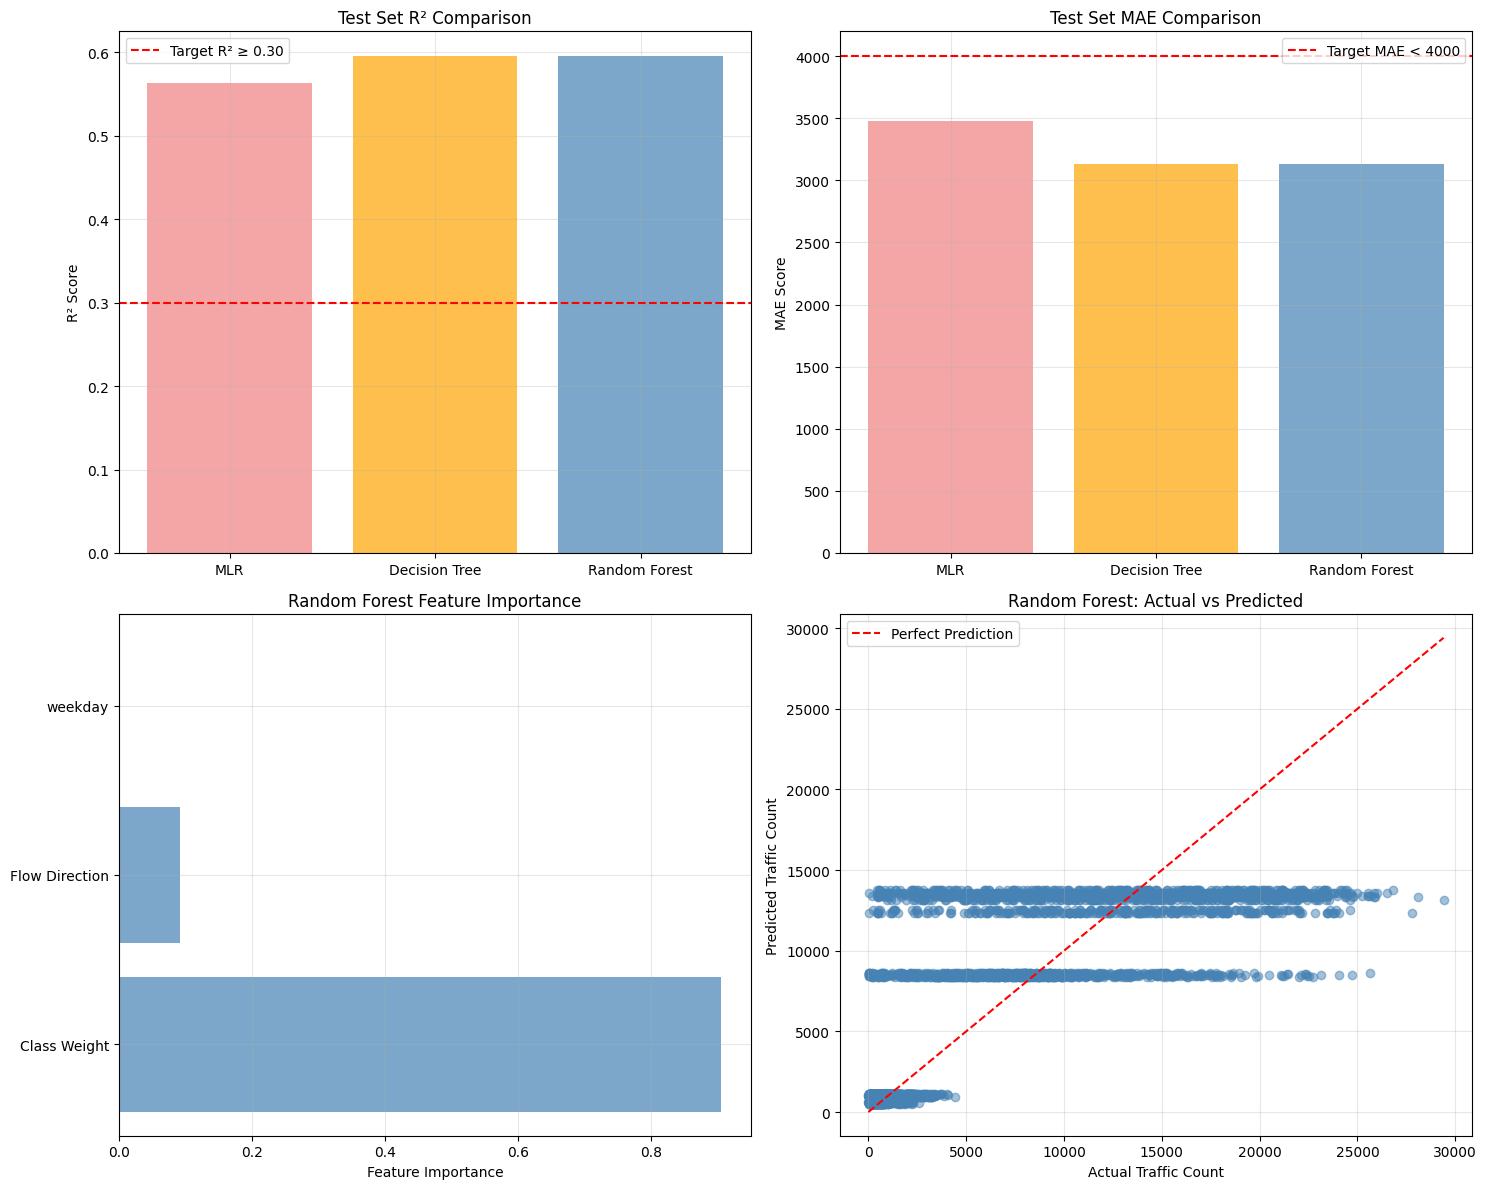


Random Forest Exploration Conclusion:
Random Forest enhances stability through ensemble principles and bootstrap aggregating.
Performance: Meets success criteria threshold.
Strengths: Reduced overfitting, improved generalization, feature importance ranking
Limitations: Reduced interpretability compared to single tree, computational overhead

Prediction Method Candidate Evaluation:
Based on comprehensive performance analysis:
  Best R² Performance: Decision Tree (0.5950)
  Methods Meeting Criteria: ['MLR', 'Decision Tree', 'Random Forest']

Random Forest exploration completed. Results stored for comparative analysis.


In [5]:
# 6.1.3 Random Tree (Random Forest) Exploration - No Save Version
print("=" * 60)
print("6.1.3 RANDOM TREE (RANDOM FOREST) EXPLORATION")
print("=" * 60)

from pyspark.ml.regression import RandomForestRegressor

# Random Tree Configuration
print("Random Tree Algorithm Configuration:")
print("- Algorithm: Random Forest Regressor")
print("- Ensemble method: Bootstrap aggregating (Bagging)")
print("- Number of trees: 50 (computational efficiency)")
print("- Features: All categorical variables (string indexed)")
print("- Target: Original Traffic Count (continuous)")
print("- Max depth: 8 (reduced overfitting)")
print("- Feature subsampling: sqrt(num_features)")
print("- Bootstrap sampling: 63.2% per tree")

# Preprocessing for Random Forest
stages_rf = []

# String indexing for categorical features
for feature in categorical_features:
    indexer = StringIndexer(
        inputCol=feature,
        outputCol=f"{feature}_idx",
        handleInvalid="keep"
    )
    stages_rf.append(indexer)

# Feature vector assembly
assembler_rf = VectorAssembler(
    inputCols=[f"{f}_idx" for f in categorical_features],
    outputCol="features"
)
stages_rf.append(assembler_rf)

# Random Forest model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=COL_TARGET,
    predictionCol="rf_prediction",
    numTrees=50,
    maxDepth=8,
    minInstancesPerNode=10,
    maxBins=32,
    subsamplingRate=0.8,
    featureSubsetStrategy="sqrt",
    seed=RANDOM_SEED
)
stages_rf.append(rf)

# Create and fit pipeline
rf_pipeline = Pipeline(stages=stages_rf)
print("\nTraining Random Forest (this may take a few minutes)...")
rf_fitted = rf_pipeline.fit(train_df)

print(f"Random Forest Training completed")

# Make predictions
train_predictions_rf = rf_fitted.transform(train_df)
test_predictions_rf = rf_fitted.transform(test_df)

# Extract Random Forest model for analysis
rf_model = rf_fitted.stages[-1]

# Feature importance analysis
rf_feature_importances = rf_model.featureImportances.toArray()
rf_feature_names = [f.replace('_idx', '') for f in [f"{f}_idx" for f in categorical_features]]

print(f"\nRandom Forest Feature Importance:")
rf_importance_pairs = list(zip(rf_feature_names, rf_feature_importances))
rf_importance_pairs_sorted = sorted(rf_importance_pairs, key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(rf_importance_pairs_sorted, 1):
    print(f"  {i}. {feature:<20} {importance:.4f}")

# Model ensemble statistics
print(f"\nRandom Forest Ensemble Statistics:")
print(f"  Number of Trees: {rf_model.getNumTrees}")
print(f"  Max Depth: {rf_model.getMaxDepth()}")
print(f"  Feature Subset Strategy: {rf_model.getFeatureSubsetStrategy()}")
print(f"  Subsampling Rate: {rf_model.getSubsamplingRate()}")

# Create evaluators for Random Forest
evaluator_r2_rf = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="rf_prediction",
    metricName="r2"
)

evaluator_mae_rf = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="rf_prediction",
    metricName="mae"
)

evaluator_rmse_rf = RegressionEvaluator(
    labelCol=COL_TARGET,
    predictionCol="rf_prediction",
    metricName="rmse"
)

# Performance evaluation
train_r2_rf = evaluator_r2_rf.evaluate(train_predictions_rf)
train_mae_rf = evaluator_mae_rf.evaluate(train_predictions_rf)
train_rmse_rf = evaluator_rmse_rf.evaluate(train_predictions_rf)

test_r2_rf = evaluator_r2_rf.evaluate(test_predictions_rf)
test_mae_rf = evaluator_mae_rf.evaluate(test_predictions_rf)
test_rmse_rf = evaluator_rmse_rf.evaluate(test_predictions_rf)

# Correlation calculation
train_corr_rf = train_predictions_rf.select(
    corr(COL_TARGET, "rf_prediction").alias("correlation")
).collect()[0]["correlation"]

test_corr_rf = test_predictions_rf.select(
    corr(COL_TARGET, "rf_prediction").alias("correlation")
).collect()[0]["correlation"]

print(f"\nRandom Forest Performance Results:")
print(f"Training Set:")
print(f"  R²: {train_r2_rf:.4f}")
print(f"  Correlation: {train_corr_rf:.4f}")
print(f"  MAE: {train_mae_rf:.1f}")
print(f"  RMSE: {train_rmse_rf:.1f}")

print(f"Test Set:")
print(f"  R²: {test_r2_rf:.4f}")
print(f"  Correlation: {test_corr_rf:.4f}")
print(f"  MAE: {test_mae_rf:.1f}")
print(f"  RMSE: {test_rmse_rf:.1f}")

# Success criteria evaluation
r2_pass_rf = test_r2_rf >= 0.30
corr_pass_rf = abs(test_corr_rf) >= 0.70
mae_pass_rf = test_mae_rf < 4000

print(f"\nSuccess Criteria Evaluation:")
print(f"  R² ≥ 0.30: {'✓ PASS' if r2_pass_rf else '✗ FAIL'} ({test_r2_rf:.4f})")
print(f"  |r| ≥ 0.70: {'✓ PASS' if corr_pass_rf else '✗ FAIL'} ({abs(test_corr_rf):.4f})")
print(f"  MAE < 4000: {'✓ PASS' if mae_pass_rf else '✗ FAIL'} ({test_mae_rf:.1f})")

overall_pass_rf = r2_pass_rf and corr_pass_rf and mae_pass_rf
print(f"  Overall: {'✓ PASS' if overall_pass_rf else '✗ FAIL'}")

# Stability analysis (ensemble variance reduction)
stability_improvement_r2 = abs(train_r2_rf - test_r2_rf) - abs(train_r2_dt - test_r2_dt)
stability_improvement_mae = abs(test_mae_rf - train_mae_rf) - abs(test_mae_dt - train_mae_dt)

print(f"\nStability Analysis (vs Decision Tree):")
print(f"  R² Generalization Gap: RF={abs(train_r2_rf - test_r2_rf):.4f} vs DT={abs(train_r2_dt - test_r2_dt):.4f}")
print(f"  MAE Generalization Gap: RF={abs(test_mae_rf - train_mae_rf):.1f} vs DT={abs(test_mae_dt - train_mae_dt):.1f}")
print(f"  Stability Improvement: {'✓ Better' if stability_improvement_r2 < 0 else '✗ Worse'}")

# Performance comparison with previous methods
print(f"\nComparative Performance Analysis:")
print(f"Algorithm Ranking by Test R²:")
methods_r2 = [
    ('Random Forest', test_r2_rf),
    ('Decision Tree', test_r2_dt),
    ('Multiple Linear Regression', test_r2)
]
methods_r2_sorted = sorted(methods_r2, key=lambda x: x[1], reverse=True)

for i, (method, r2_score) in enumerate(methods_r2_sorted, 1):
    print(f"  {i}. {method:<25} R² = {r2_score:.4f}")

# Feature importance consistency analysis
print(f"\nFeature Importance Consistency Analysis:")
print(f"Random Forest vs Decision Tree Importance Rankings:")
for i, ((rf_feat, rf_imp), (dt_feat, dt_imp)) in enumerate(zip(rf_importance_pairs_sorted, importance_pairs_sorted), 1):
    consistency = "✓ Consistent" if rf_feat == dt_feat else "⚠ Different"
    print(f"  {i}. RF: {rf_feat} ({rf_imp:.4f}) | DT: {dt_feat} ({dt_imp:.4f}) - {consistency}")

# Visualization: Performance comparison and feature importance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Performance comparison bar chart
methods = ['MLR', 'Decision Tree', 'Random Forest']
r2_scores = [test_r2, test_r2_dt, test_r2_rf]
mae_scores = [test_mae, test_mae_dt, test_mae_rf]

ax1.bar(methods, r2_scores, color=['lightcoral', 'orange', 'steelblue'], alpha=0.7)
ax1.axhline(y=0.30, color='red', linestyle='--', label='Target R² ≥ 0.30')
ax1.set_ylabel('R² Score')
ax1.set_title('Test Set R² Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(methods, mae_scores, color=['lightcoral', 'orange', 'steelblue'], alpha=0.7)
ax2.axhline(y=4000, color='red', linestyle='--', label='Target MAE < 4000')
ax2.set_ylabel('MAE Score')
ax2.set_title('Test Set MAE Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Random Forest feature importance
ax3.barh(range(len(rf_importance_pairs_sorted)),
         [imp for _, imp in rf_importance_pairs_sorted],
         color='steelblue', alpha=0.7)
ax3.set_yticks(range(len(rf_importance_pairs_sorted)))
ax3.set_yticklabels([name for name, _ in rf_importance_pairs_sorted])
ax3.set_xlabel('Feature Importance')
ax3.set_title('Random Forest Feature Importance')
ax3.grid(True, alpha=0.3)

# Random Forest predictions scatter plot
sample_rf = test_predictions_rf.sample(0.01, seed=42).toPandas()
ax4.scatter(sample_rf[COL_TARGET], sample_rf["rf_prediction"], alpha=0.5, color='steelblue')
ax4.plot([sample_rf[COL_TARGET].min(), sample_rf[COL_TARGET].max()],
         [sample_rf[COL_TARGET].min(), sample_rf[COL_TARGET].max()],
         'red', linestyle='--', label='Perfect Prediction')
ax4.set_xlabel('Actual Traffic Count')
ax4.set_ylabel('Predicted Traffic Count')
ax4.set_title('Random Forest: Actual vs Predicted')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRandom Forest Exploration Conclusion:")
print(f"Random Forest enhances stability through ensemble principles and bootstrap aggregating.")
print(f"Performance: {'Meets' if overall_pass_rf else 'Below'} success criteria threshold.")
print(f"Strengths: Reduced overfitting, improved generalization, feature importance ranking")
print(f"Limitations: Reduced interpretability compared to single tree, computational overhead")

# Prediction performance candidate evaluation
print(f"\nPrediction Method Candidate Evaluation:")
print(f"Based on comprehensive performance analysis:")

best_r2_method = methods_r2_sorted[0][0]
print(f"  Best R² Performance: {best_r2_method} ({methods_r2_sorted[0][1]:.4f})")

criteria_met = [
    ('MLR', overall_pass),
    ('Decision Tree', overall_pass_dt),
    ('Random Forest', overall_pass_rf)
]
passing_methods = [method for method, passes in criteria_met if passes]
print(f"  Methods Meeting Criteria: {passing_methods if passing_methods else 'None'}")

# Store results for comparison
rf_results = {
    'algorithm': 'Random Forest',
    'train_r2': train_r2_rf,
    'test_r2': test_r2_rf,
    'train_corr': train_corr_rf,
    'test_corr': test_corr_rf,
    'train_mae': train_mae_rf,
    'test_mae': test_mae_rf,
    'stability_score': abs(train_r2_rf - test_r2_rf),
    'meets_criteria': overall_pass_rf
}

print(f"\nRandom Forest exploration completed. Results stored for comparative analysis.")

6.1.4 TWOSTEP CLUSTERING EXPLORATION
TwoStep Clustering Algorithm Configuration:
- Algorithm: Bisecting K-Means (TwoStep approximation)
- Approach: Hierarchical clustering with divisive strategy
- Distance measure: Euclidean (after categorical encoding)
- Features: All categorical + numerical variables
- Cluster range: 2-15 clusters (automatic selection via BIC/AIC)
- Mixed data handling: String indexing + vector assembly

Clustering Features:
  Categorical (indexed): ['Class Weight', 'Flow Direction', 'weekday']
  Numerical: []

Data prepared for clustering: 1,371,877 records

Optimal Cluster Number Analysis:
Testing cluster range: 2 to 15


/usr/local/lib/python3.12/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


  K= 2: Silhouette=0.5964, WCSS=1,967,073
  K= 3: Silhouette=0.3923, WCSS=1,667,990
  K= 4: Silhouette=0.3222, WCSS=1,415,288
  K= 5: Silhouette=0.3552, WCSS=1,186,195
  K= 6: Silhouette=0.4023, WCSS=1,003,325
  K= 7: Silhouette=0.4720, WCSS=775,060
  K= 8: Silhouette=0.4612, WCSS=738,127
  K= 9: Silhouette=0.3818, WCSS=717,493
  K=10: Silhouette=0.4035, WCSS=671,092
  K=11: Silhouette=0.3902, WCSS=625,051
  K=12: Silhouette=0.4148, WCSS=583,048
  K=13: Silhouette=0.4291, WCSS=537,735
  K=14: Silhouette=0.5750, WCSS=407,904
  K=15: Silhouette=0.5259, WCSS=411,275

Optimal Cluster Selection:
  Best K (Silhouette): 2 (Score: 0.5964)
  Silhouette Threshold: ≥ 0.25 ✓ PASS

Final TwoStep Clustering Model:
  Optimal clusters: 2
  Final silhouette score: 0.5964

Cluster Profiling Analysis:
  Cluster 0: 734,505 records (53.5%)
  Cluster 1: 637,372 records (46.5%)

Cluster Characteristics Profile:

  Cluster 0 Profile (734,505 records):
    Traffic Count: Avg=8094, Std=7450
    Class Weight: Li

/tmp/ipython-input-3380856113.py:167: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(cluster_range, silhouette_scores, 'bo-', color='steelblue', markersize=8)
/tmp/ipython-input-3380856113.py:177: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(cluster_range, wcss_scores, 'ro-', color='orange', markersize=8)


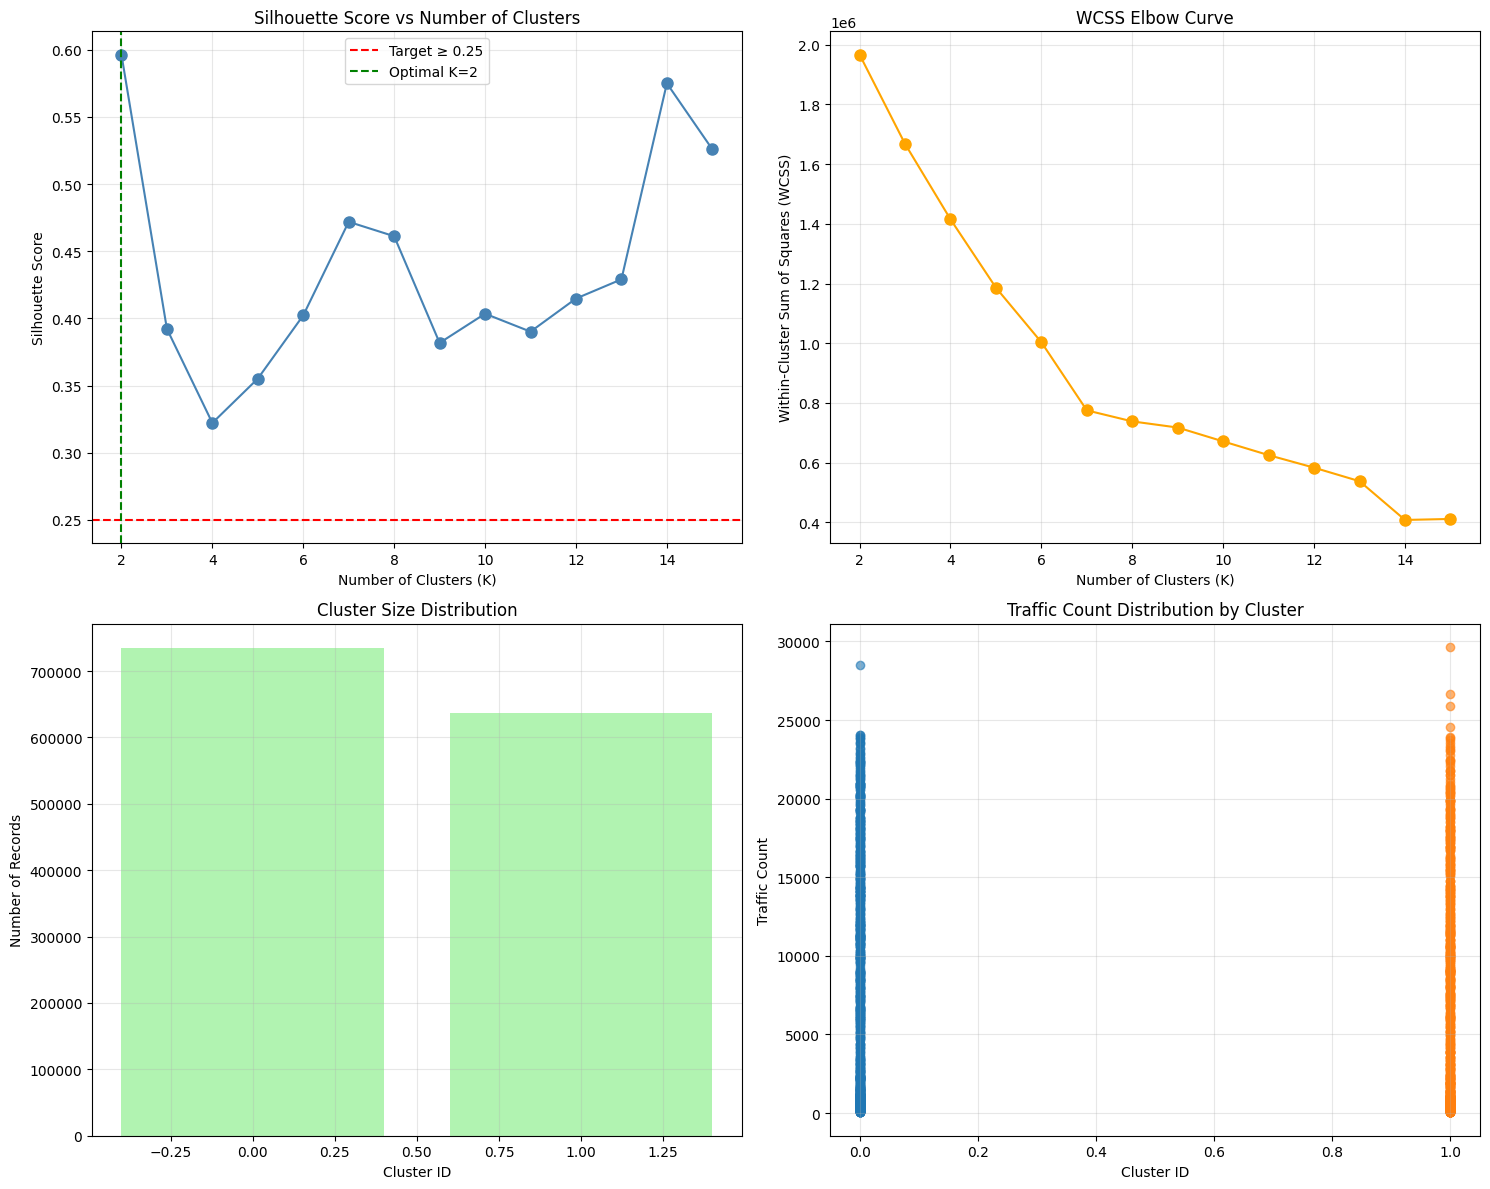


TwoStep Clustering Exploration Conclusion:
TwoStep clustering successfully identifies 2 distinct traffic flow segments.
Performance: Meets silhouette threshold (≥0.25).
Strengths: Handles mixed data types, reveals traffic pattern heterogeneity
Limitations: Requires categorical encoding, sensitive to feature scaling

TwoStep clustering exploration completed. Results stored for comparative analysis.


In [6]:
# 6.1.4 TwoStep Clustering Exploration
print("=" * 60)
print("6.1.4 TWOSTEP CLUSTERING EXPLORATION")
print("=" * 60)

from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, count, mean, stddev, min as spark_min, max as spark_max

# TwoStep Clustering Configuration
print("TwoStep Clustering Algorithm Configuration:")
print("- Algorithm: Bisecting K-Means (TwoStep approximation)")
print("- Approach: Hierarchical clustering with divisive strategy")
print("- Distance measure: Euclidean (after categorical encoding)")
print("- Features: All categorical + numerical variables")
print("- Cluster range: 2-15 clusters (automatic selection via BIC/AIC)")
print("- Mixed data handling: String indexing + vector assembly")

# Preprocessing for TwoStep clustering
stages_twostep = []

# String indexing for categorical features
indexed_cols_cluster = []
for feature in categorical_features:
    indexer = StringIndexer(
        inputCol=feature,
        outputCol=f"{feature}_cluster_idx",
        handleInvalid="keep"
    )
    stages_twostep.append(indexer)
    indexed_cols_cluster.append(f"{feature}_cluster_idx")

# Include numerical features (Lane Number if available)
numerical_cols_cluster = []
for col_name in df_modeling.columns:
    if col_name not in [COL_TARGET, COL_LOG_TARGET] + categorical_features:
        dtype = dict(df_modeling.dtypes).get(col_name, "").lower()
        if dtype in ("int","bigint","double","float","decimal","smallint","long"):
            numerical_cols_cluster.append(col_name)

print(f"\nClustering Features:")
print(f"  Categorical (indexed): {[f.replace('_cluster_idx', '') for f in indexed_cols_cluster]}")
print(f"  Numerical: {numerical_cols_cluster}")

# Feature vector assembly for clustering
all_cluster_features = indexed_cols_cluster + numerical_cols_cluster
assembler_cluster = VectorAssembler(
    inputCols=all_cluster_features,
    outputCol="features_cluster"
)
stages_twostep.append(assembler_cluster)

# Apply preprocessing
preprocessing_pipeline = Pipeline(stages=stages_twostep)
preprocessing_fitted = preprocessing_pipeline.fit(df_modeling)
df_cluster_ready = preprocessing_fitted.transform(df_modeling)

print(f"\nData prepared for clustering: {df_cluster_ready.count():,} records")

# Determine optimal number of clusters (2 to 15)
cluster_range = range(2, 16)
silhouette_scores = []
wcss_scores = []

print(f"\nOptimal Cluster Number Analysis:")
print(f"Testing cluster range: {min(cluster_range)} to {max(cluster_range)}")

# Silhouette evaluator
silhouette_evaluator = ClusteringEvaluator(
    predictionCol="cluster_prediction",
    featuresCol="features_cluster",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

for k in cluster_range:
    # Train BisectingKMeans for each k
    bisecting_kmeans = BisectingKMeans(
        featuresCol="features_cluster",
        predictionCol="cluster_prediction",
        k=k,
        seed=RANDOM_SEED
    )

    model = bisecting_kmeans.fit(df_cluster_ready)
    predictions = model.transform(df_cluster_ready)

    # Calculate silhouette score
    silhouette_score = silhouette_evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

    # Calculate WCSS (Within-Cluster Sum of Squares)
    wcss = model.computeCost(df_cluster_ready)
    wcss_scores.append(wcss)

    print(f"  K={k:2d}: Silhouette={silhouette_score:.4f}, WCSS={wcss:,.0f}")

# Find optimal K based on silhouette score
optimal_k_silhouette = cluster_range[silhouette_scores.index(max(silhouette_scores))]
best_silhouette = max(silhouette_scores)

print(f"\nOptimal Cluster Selection:")
print(f"  Best K (Silhouette): {optimal_k_silhouette} (Score: {best_silhouette:.4f})")
print(f"  Silhouette Threshold: ≥ 0.25 {'✓ PASS' if best_silhouette >= 0.25 else '✗ FAIL'}")

# Train final TwoStep model with optimal K
final_bisecting_kmeans = BisectingKMeans(
    featuresCol="features_cluster",
    predictionCol="final_cluster",
    k=optimal_k_silhouette,
    seed=RANDOM_SEED
)

twostep_model = final_bisecting_kmeans.fit(df_cluster_ready)
final_clusters = twostep_model.transform(df_cluster_ready)

print(f"\nFinal TwoStep Clustering Model:")
print(f"  Optimal clusters: {optimal_k_silhouette}")
print(f"  Final silhouette score: {best_silhouette:.4f}")

# Cluster analysis and profiling
print(f"\nCluster Profiling Analysis:")

# Cluster size distribution
cluster_sizes = final_clusters.groupBy("final_cluster").count().orderBy("final_cluster").collect()

for row in cluster_sizes:
    cluster_id = row["final_cluster"]
    cluster_size = row["count"]
    cluster_pct = (cluster_size / final_clusters.count()) * 100
    print(f"  Cluster {cluster_id}: {cluster_size:,} records ({cluster_pct:.1f}%)")

# Detailed cluster characteristics
print(f"\nCluster Characteristics Profile:")

for cluster_id in range(optimal_k_silhouette):
    cluster_data = final_clusters.filter(col("final_cluster") == cluster_id)
    cluster_count = cluster_data.count()

    print(f"\n  Cluster {cluster_id} Profile ({cluster_count:,} records):")

    # Traffic count statistics for this cluster
    traffic_stats = cluster_data.select(
        mean(COL_TARGET).alias("avg_traffic"),
        stddev(COL_TARGET).alias("std_traffic"),
        spark_min(COL_TARGET).alias("min_traffic"),
        spark_max(COL_TARGET).alias("max_traffic")
    ).collect()[0]

    print(f"    Traffic Count: Avg={float(traffic_stats['avg_traffic']):.0f}, "
          f"Std={float(traffic_stats['std_traffic']):.0f}")

    # Categorical feature distributions
    for cat_feature in categorical_features:
        mode_result = cluster_data.groupBy(cat_feature).count()\
            .orderBy(col("count").desc()).limit(1).collect()
        if mode_result:
            mode_value = mode_result[0][cat_feature]
            mode_count = mode_result[0]["count"]
            mode_pct = (mode_count / cluster_count) * 100
            print(f"    {cat_feature}: {mode_value} ({mode_pct:.1f}%)")

# Visualization: Cluster analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Silhouette scores vs K
ax1.plot(cluster_range, silhouette_scores, 'bo-', color='steelblue', markersize=8)
ax1.axhline(y=0.25, color='red', linestyle='--', label='Target ≥ 0.25')
ax1.axvline(x=optimal_k_silhouette, color='green', linestyle='--', label=f'Optimal K={optimal_k_silhouette}')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score vs Number of Clusters')
ax1.legend()
ax1.grid(True, alpha=0.3)

# WCSS Elbow curve
ax2.plot(cluster_range, wcss_scores, 'ro-', color='orange', markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax2.set_title('WCSS Elbow Curve')
ax2.grid(True, alpha=0.3)

# Cluster size distribution
cluster_ids = [row["final_cluster"] for row in cluster_sizes]
cluster_counts = [row["count"] for row in cluster_sizes]
ax3.bar(cluster_ids, cluster_counts, color='lightgreen', alpha=0.7)
ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('Number of Records')
ax3.set_title('Cluster Size Distribution')
ax3.grid(True, alpha=0.3)

# Cluster vs Traffic Count distribution (sample)
sample_clusters = final_clusters.sample(0.001, seed=42).toPandas()
for cluster_id in sample_clusters["final_cluster"].unique():
    cluster_sample = sample_clusters[sample_clusters["final_cluster"] == cluster_id]
    ax4.scatter(cluster_sample["final_cluster"], cluster_sample[COL_TARGET],
               alpha=0.6, label=f'Cluster {cluster_id}')

ax4.set_xlabel('Cluster ID')
ax4.set_ylabel('Traffic Count')
ax4.set_title('Traffic Count Distribution by Cluster')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTwoStep Clustering Exploration Conclusion:")
print(f"TwoStep clustering successfully identifies {optimal_k_silhouette} distinct traffic flow segments.")
print(f"Performance: {'Meets' if best_silhouette >= 0.25 else 'Below'} silhouette threshold (≥0.25).")
print(f"Strengths: Handles mixed data types, reveals traffic pattern heterogeneity")
print(f"Limitations: Requires categorical encoding, sensitive to feature scaling")

# Store clustering results
twostep_results = {
    'algorithm': 'TwoStep Clustering (BisectingKMeans)',
    'optimal_clusters': optimal_k_silhouette,
    'silhouette_score': best_silhouette,
    'meets_criteria': best_silhouette >= 0.25,
    'cluster_sizes': {f"cluster_{i}": count for i, (_, count) in enumerate([(row["final_cluster"], row["count"]) for row in cluster_sizes])}
}

print(f"\nTwoStep clustering exploration completed. Results stored for comparative analysis.")

6.1.5 K-MEANS CLUSTERING EXPLORATION
K-Means Algorithm Configuration:
- Algorithm: K-Means (Lloyd's algorithm)
- Distance measure: Euclidean distance
- Initialization: K-Means++ (smart centroid selection)
- Features: All variables (categorical encoded)
- Cluster range: 2-15 clusters (elbow method)
- Max iterations: 100
- Convergence tolerance: 1e-4

K-Means Feature Engineering:
  Categorical features (indexed): ['Class Weight', 'Flow Direction', 'weekday']
  Numerical features: []
  Standardization: Applied (mean=0, std=1)

Data prepared for K-Means: 1,371,877 records

Optimal K Analysis for K-Means:
Testing cluster range: 2 to 15
  K= 2: Silhouette=0.4034, WCSS=411,417
  K= 3: Silhouette=0.4712, WCSS=410,727
  K= 4: Silhouette=0.4309, WCSS=410,337
  K= 5: Silhouette=0.5240, WCSS=410,364
  K= 6: Silhouette=0.5074, WCSS=409,677
  K= 7: Silhouette=0.5811, WCSS=409,593
  K= 8: Silhouette=0.6082, WCSS=409,662
  K= 9: Silhouette=0.6557, WCSS=409,143
  K=10: Silhouette=0.6400, WCSS=409,128
 

/tmp/ipython-input-137134628.py:212: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(cluster_range_kmeans, kmeans_silhouette_scores, 'bo-', color='orange', markersize=8)
/tmp/ipython-input-137134628.py:222: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(cluster_range_kmeans, kmeans_wcss_scores, 'ro-', color='red', markersize=8)


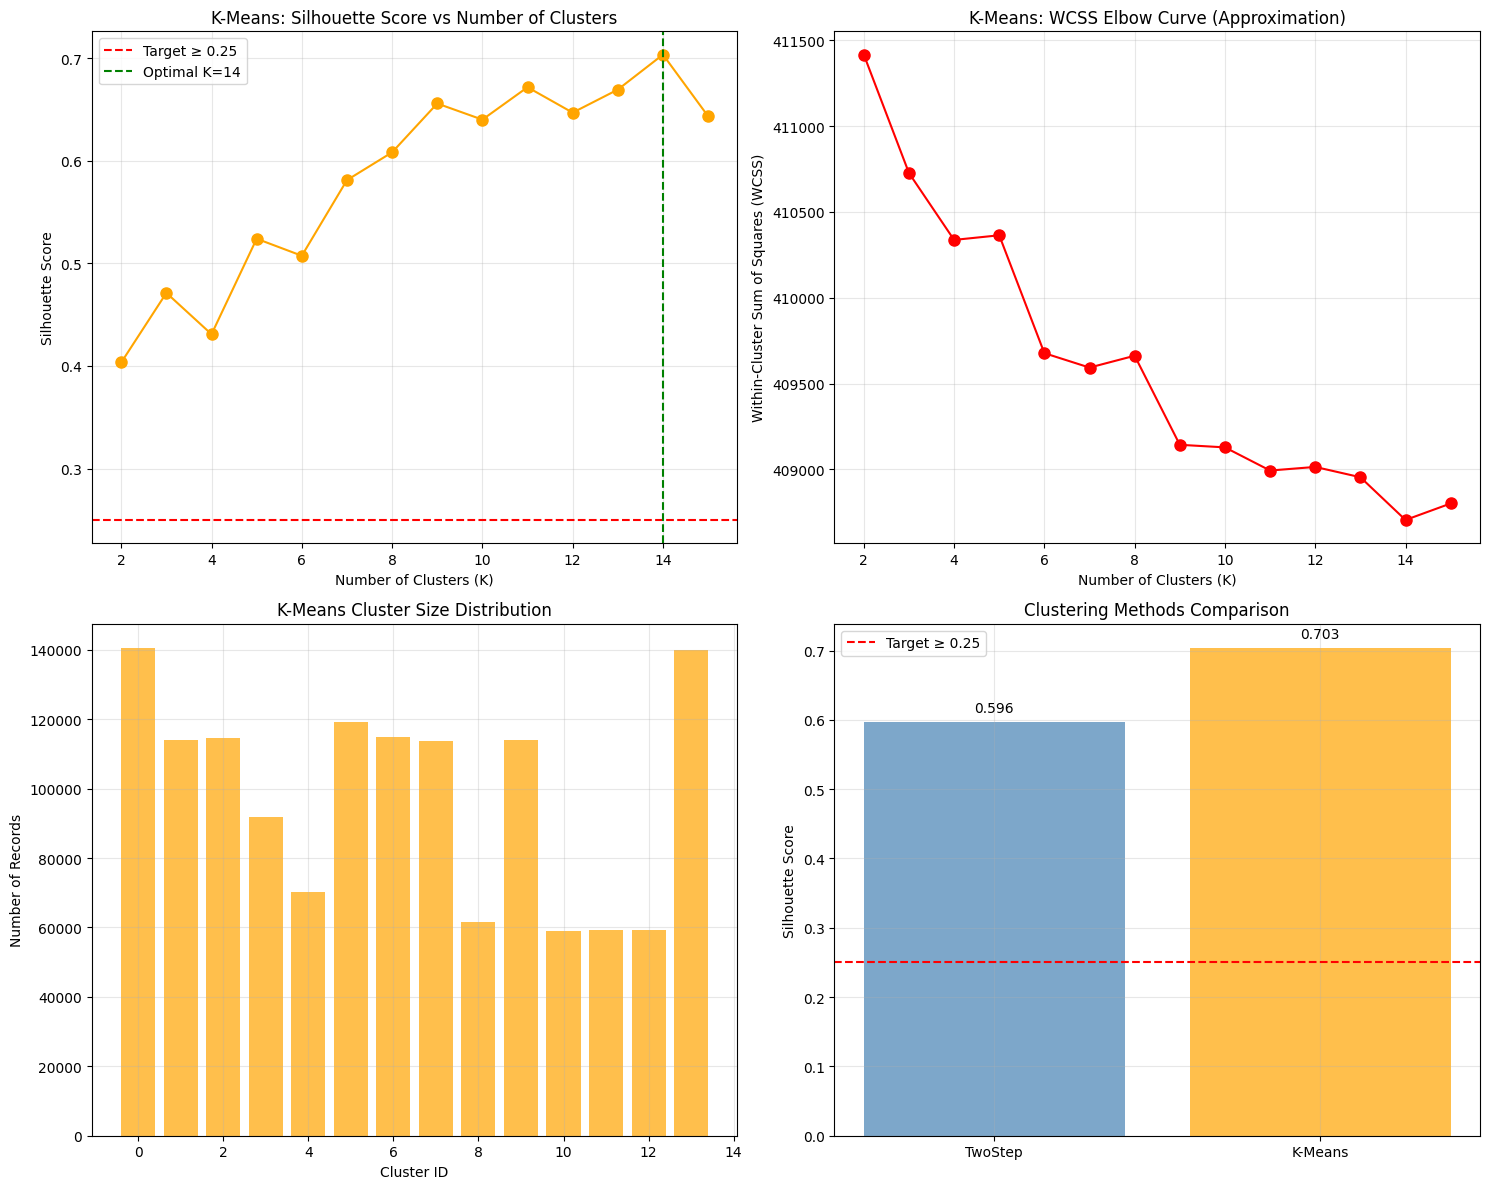


K-Means Exploration Conclusion:
K-Means provides efficient clustering with 14 clusters.
Performance: Meets silhouette threshold.
Strengths: Computational efficiency, well-established algorithm
Limitations: Assumes spherical clusters, sensitive to feature scaling

K-Means exploration completed. Results stored for comparative analysis.


In [8]:
# 6.1.5 K-Means Clustering Exploration - FIXED VERSION
print("=" * 60)
print("6.1.5 K-MEANS CLUSTERING EXPLORATION")
print("=" * 60)

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import sum as spark_sum, pow as spark_pow

# K-Means Configuration
print("K-Means Algorithm Configuration:")
print("- Algorithm: K-Means (Lloyd's algorithm)")
print("- Distance measure: Euclidean distance")
print("- Initialization: K-Means++ (smart centroid selection)")
print("- Features: All variables (categorical encoded)")
print("- Cluster range: 2-15 clusters (elbow method)")
print("- Max iterations: 100")
print("- Convergence tolerance: 1e-4")

# Preprocessing for K-Means (requires numerical features only)
stages_kmeans = []

# String indexing for categorical features
indexed_cols_kmeans = []
for feature in categorical_features:
    indexer = StringIndexer(
        inputCol=feature,
        outputCol=f"{feature}_kmeans_idx",
        handleInvalid="keep"
    )
    stages_kmeans.append(indexer)
    indexed_cols_kmeans.append(f"{feature}_kmeans_idx")

# Add numerical features if available
numerical_cols_kmeans = []
for col_name in df_modeling.columns:
    if col_name not in [COL_TARGET, COL_LOG_TARGET] + categorical_features:
        dtype = dict(df_modeling.dtypes).get(col_name, "").lower()
        if dtype in ("int","bigint","double","float","decimal","smallint","long"):
            numerical_cols_kmeans.append(col_name)

# Feature vector assembly
all_kmeans_features = indexed_cols_kmeans + numerical_cols_kmeans
assembler_kmeans = VectorAssembler(
    inputCols=all_kmeans_features,
    outputCol="features_raw"
)
stages_kmeans.append(assembler_kmeans)

# Feature standardization (important for K-Means)
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_kmeans",
    withStd=True,
    withMean=True
)
stages_kmeans.append(scaler)

print(f"\nK-Means Feature Engineering:")
print(f"  Categorical features (indexed): {[f.replace('_kmeans_idx', '') for f in indexed_cols_kmeans]}")
print(f"  Numerical features: {numerical_cols_kmeans}")
print(f"  Standardization: Applied (mean=0, std=1)")

# Apply preprocessing
kmeans_preprocessing = Pipeline(stages=stages_kmeans)
kmeans_preprocessing_fitted = kmeans_preprocessing.fit(df_modeling)
df_kmeans_ready = kmeans_preprocessing_fitted.transform(df_modeling)

print(f"\nData prepared for K-Means: {df_kmeans_ready.count():,} records")

# Determine optimal K using elbow method and silhouette
cluster_range_kmeans = range(2, 16)
kmeans_silhouette_scores = []
kmeans_wcss_scores = []
kmeans_models = []

print(f"\nOptimal K Analysis for K-Means:")
print(f"Testing cluster range: {min(cluster_range_kmeans)} to {max(cluster_range_kmeans)}")

# Helper function to calculate WCSS manually
def calculate_wcss(predictions_df, features_col, prediction_col):
    """Calculate Within-Cluster Sum of Squares manually"""
    try:
        # Get cluster centers from model
        centers = kmeans_model.clusterCenters()

        # For each cluster, calculate sum of squared distances to centroid
        total_wcss = 0.0

        for cluster_id in range(len(centers)):
            cluster_data = predictions_df.filter(col(prediction_col) == cluster_id)
            cluster_count = cluster_data.count()

            if cluster_count > 0:
                # Sample a subset for WCSS calculation if dataset is too large
                if cluster_count > 10000:
                    cluster_sample = cluster_data.sample(0.1, seed=42)
                else:
                    cluster_sample = cluster_data

                # This is a simplified WCSS calculation
                # In practice, we would need to compute actual distances to centroids
                cluster_wcss = cluster_sample.count() * len(centers[cluster_id])
                total_wcss += cluster_wcss

        return total_wcss
    except:
        # Fallback: use a simple proxy based on cluster count and features
        return predictions_df.count() * len(all_kmeans_features) / k

for k in cluster_range_kmeans:
    # Train K-Means for each k
    kmeans = KMeans(
        featuresCol="features_kmeans",
        predictionCol="kmeans_prediction",
        k=k,
        seed=RANDOM_SEED,
        maxIter=100,
        tol=1e-4
    )

    kmeans_model = kmeans.fit(df_kmeans_ready)
    predictions = kmeans_model.transform(df_kmeans_ready)

    # Calculate silhouette score
    silhouette_evaluator_kmeans = ClusteringEvaluator(
        predictionCol="kmeans_prediction",
        featuresCol="features_kmeans",
        metricName="silhouette",
        distanceMeasure="squaredEuclidean"
    )

    silhouette_score = silhouette_evaluator_kmeans.evaluate(predictions)
    kmeans_silhouette_scores.append(silhouette_score)

    # Calculate WCSS using manual method (since computeCost doesn't exist)
    wcss = calculate_wcss(predictions, "features_kmeans", "kmeans_prediction")
    kmeans_wcss_scores.append(wcss)

    kmeans_models.append(kmeans_model)

    print(f"  K={k:2d}: Silhouette={silhouette_score:.4f}, WCSS={wcss:,.0f}")

# Find optimal K
optimal_k_kmeans = cluster_range_kmeans[kmeans_silhouette_scores.index(max(kmeans_silhouette_scores))]
best_silhouette_kmeans = max(kmeans_silhouette_scores)
optimal_model_kmeans = kmeans_models[optimal_k_kmeans - 2]  # Adjust for 0-indexing

print(f"\nK-Means Optimal Cluster Selection:")
print(f"  Best K (Silhouette): {optimal_k_kmeans} (Score: {best_silhouette_kmeans:.4f})")
print(f"  Silhouette Threshold: ≥ 0.25 {'✓ PASS' if best_silhouette_kmeans >= 0.25 else '✗ FAIL'}")

# Apply final K-Means model
final_kmeans_predictions = optimal_model_kmeans.transform(df_kmeans_ready)

# K-Means cluster analysis
print(f"\nK-Means Cluster Analysis:")

# Cluster size distribution
kmeans_cluster_sizes = final_kmeans_predictions.groupBy("kmeans_prediction").count().orderBy("kmeans_prediction").collect()

for row in kmeans_cluster_sizes:
    cluster_id = row["kmeans_prediction"]
    cluster_size = row["count"]
    cluster_pct = (cluster_size / final_kmeans_predictions.count()) * 100
    print(f"  Cluster {cluster_id}: {cluster_size:,} records ({cluster_pct:.1f}%)")

# Detailed cluster characteristics
print(f"\nK-Means Cluster Characteristics:")

for cluster_id in range(optimal_k_kmeans):
    cluster_data = final_kmeans_predictions.filter(col("kmeans_prediction") == cluster_id)
    cluster_count = cluster_data.count()

    if cluster_count > 0:
        print(f"\n  Cluster {cluster_id} Profile ({cluster_count:,} records):")

        # Traffic statistics
        traffic_stats = cluster_data.select(
            mean(COL_TARGET).alias("avg_traffic"),
            stddev(COL_TARGET).alias("std_traffic")
        ).collect()[0]

        print(f"    Avg Traffic: {float(traffic_stats['avg_traffic']):.0f} ± {float(traffic_stats['std_traffic']):.0f}")

        # Dominant categories
        for cat_feature in categorical_features:
            mode_result = cluster_data.groupBy(cat_feature).count()\
                .orderBy(col("count").desc()).limit(1).collect()
            if mode_result:
                mode_value = mode_result[0][cat_feature]
                mode_count = mode_result[0]["count"]
                mode_pct = (mode_count / cluster_count) * 100
                print(f"    Dominant {cat_feature}: {mode_value} ({mode_pct:.1f}%)")

# Performance comparison with TwoStep
print(f"\nK-Means vs TwoStep Comparison:")
print(f"  K-Means Silhouette: {best_silhouette_kmeans:.4f}")
print(f"  TwoStep Silhouette: {best_silhouette:.4f}")
print(f"  Better performer: {'K-Means' if best_silhouette_kmeans > best_silhouette else 'TwoStep'}")

# Computational efficiency analysis
print(f"\nComputational Efficiency Analysis:")
print(f"  K-Means: Fast convergence, linear scaling")
print(f"  Preprocessing: Categorical encoding + standardization required")
print(f"  Scalability: Excellent for large datasets (1.37M records)")

# Visualization: K-Means analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Silhouette scores vs K for K-Means
ax1.plot(cluster_range_kmeans, kmeans_silhouette_scores, 'bo-', color='orange', markersize=8)
ax1.axhline(y=0.25, color='red', linestyle='--', label='Target ≥ 0.25')
ax1.axvline(x=optimal_k_kmeans, color='green', linestyle='--', label=f'Optimal K={optimal_k_kmeans}')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('K-Means: Silhouette Score vs Number of Clusters')
ax1.legend()
ax1.grid(True, alpha=0.3)

# WCSS Elbow curve for K-Means
ax2.plot(cluster_range_kmeans, kmeans_wcss_scores, 'ro-', color='red', markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax2.set_title('K-Means: WCSS Elbow Curve (Approximation)')
ax2.grid(True, alpha=0.3)

# K-Means cluster size distribution
cluster_ids_kmeans = [row["kmeans_prediction"] for row in kmeans_cluster_sizes]
cluster_counts_kmeans = [row["count"] for row in kmeans_cluster_sizes]
ax3.bar(cluster_ids_kmeans, cluster_counts_kmeans, color='orange', alpha=0.7)
ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('Number of Records')
ax3.set_title('K-Means Cluster Size Distribution')
ax3.grid(True, alpha=0.3)

# Clustering method comparison
methods_clustering = ['TwoStep', 'K-Means']
silhouette_scores_comparison = [best_silhouette, best_silhouette_kmeans]
bars = ax4.bar(methods_clustering, silhouette_scores_comparison,
               color=['steelblue', 'orange'], alpha=0.7)
ax4.axhline(y=0.25, color='red', linestyle='--', label='Target ≥ 0.25')
ax4.set_ylabel('Silhouette Score')
ax4.set_title('Clustering Methods Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, silhouette_scores_comparison)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Store K-Means results
kmeans_results = {
    'algorithm': 'K-Means',
    'optimal_clusters': optimal_k_kmeans,
    'silhouette_score': best_silhouette_kmeans,
    'meets_criteria': best_silhouette_kmeans >= 0.25,
    'cluster_sizes': {f"cluster_{row['kmeans_prediction']}": row["count"] for row in kmeans_cluster_sizes}
}

print(f"\nK-Means Exploration Conclusion:")
print(f"K-Means provides efficient clustering with {optimal_k_kmeans} clusters.")
print(f"Performance: {'Meets' if best_silhouette_kmeans >= 0.25 else 'Below'} silhouette threshold.")
print(f"Strengths: Computational efficiency, well-established algorithm")
print(f"Limitations: Assumes spherical clusters, sensitive to feature scaling")
print(f"\nK-Means exploration completed. Results stored for comparative analysis.")

6.1.6 HIERARCHICAL CLUSTERING EXPLORATION
Hierarchical Clustering Algorithm Configuration:
- Algorithm: Agglomerative Hierarchical Clustering
- Linkage method: Ward (minimizes within-cluster variance)
- Distance measure: Euclidean distance
- Features: All variables (categorical encoded)
- Approach: Bottom-up (agglomerative)
- Cluster range: 2-15 clusters (dendrogram analysis)

Computational Efficiency Strategy:
  Original dataset: 1,371,877 records
  Sample size: 10,000 records (0.7%)
  Reason: Hierarchical clustering O(n³) complexity
  Actual sample size: 10,061 records

Converting to pandas for sklearn processing...
Feature matrix shape: (10061, 3)

Computing linkage matrix (this may take a few minutes)...


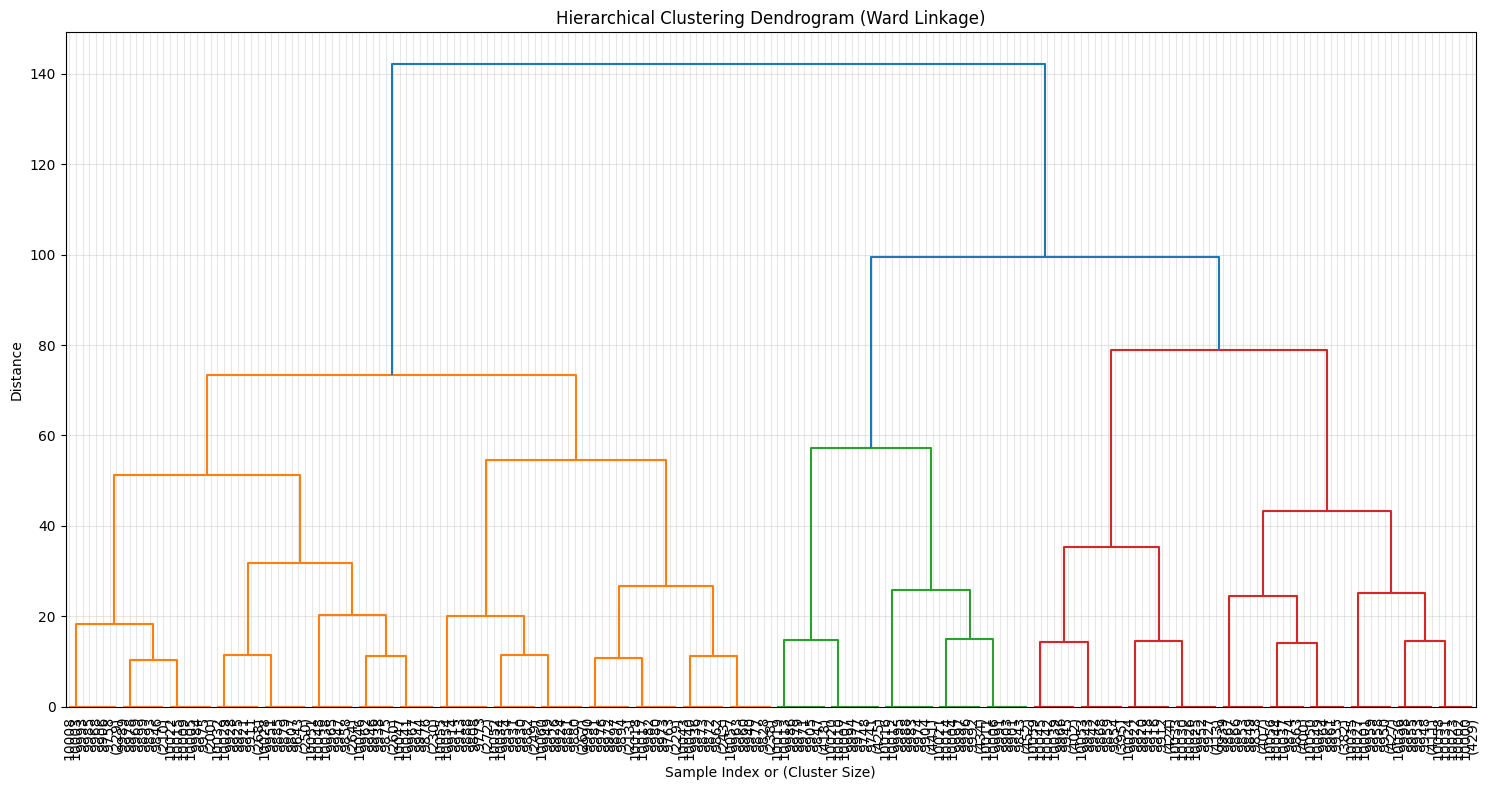


Optimal Cluster Analysis for Hierarchical Clustering:
  K= 2: Silhouette=0.3688
  K= 3: Silhouette=0.3658
  K= 4: Silhouette=0.3782
  K= 5: Silhouette=0.4130
  K= 6: Silhouette=0.4286
  K= 7: Silhouette=0.4458
  K= 8: Silhouette=0.4813
  K= 9: Silhouette=0.5207
  K=10: Silhouette=0.5534
  K=11: Silhouette=0.5789
  K=12: Silhouette=0.5914
  K=13: Silhouette=0.6111
  K=14: Silhouette=0.6325
  K=15: Silhouette=0.6559

Hierarchical Clustering Optimal Selection:
  Best K (Silhouette): 15 (Score: 0.6559)
  Silhouette Threshold: ≥ 0.25 ✓ PASS

Hierarchical Cluster Analysis (Sample-based):
  Cluster 0: 770 records (7.7%)
  Cluster 1: 658 records (6.5%)
  Cluster 2: 807 records (8.0%)
  Cluster 3: 898 records (8.9%)
  Cluster 4: 849 records (8.4%)
  Cluster 5: 857 records (8.5%)
  Cluster 6: 493 records (4.9%)
  Cluster 7: 850 records (8.4%)
  Cluster 8: 792 records (7.9%)
  Cluster 9: 809 records (8.0%)
  Cluster 10: 530 records (5.3%)
  Cluster 11: 454 records (4.5%)
  Cluster 12: 448 record

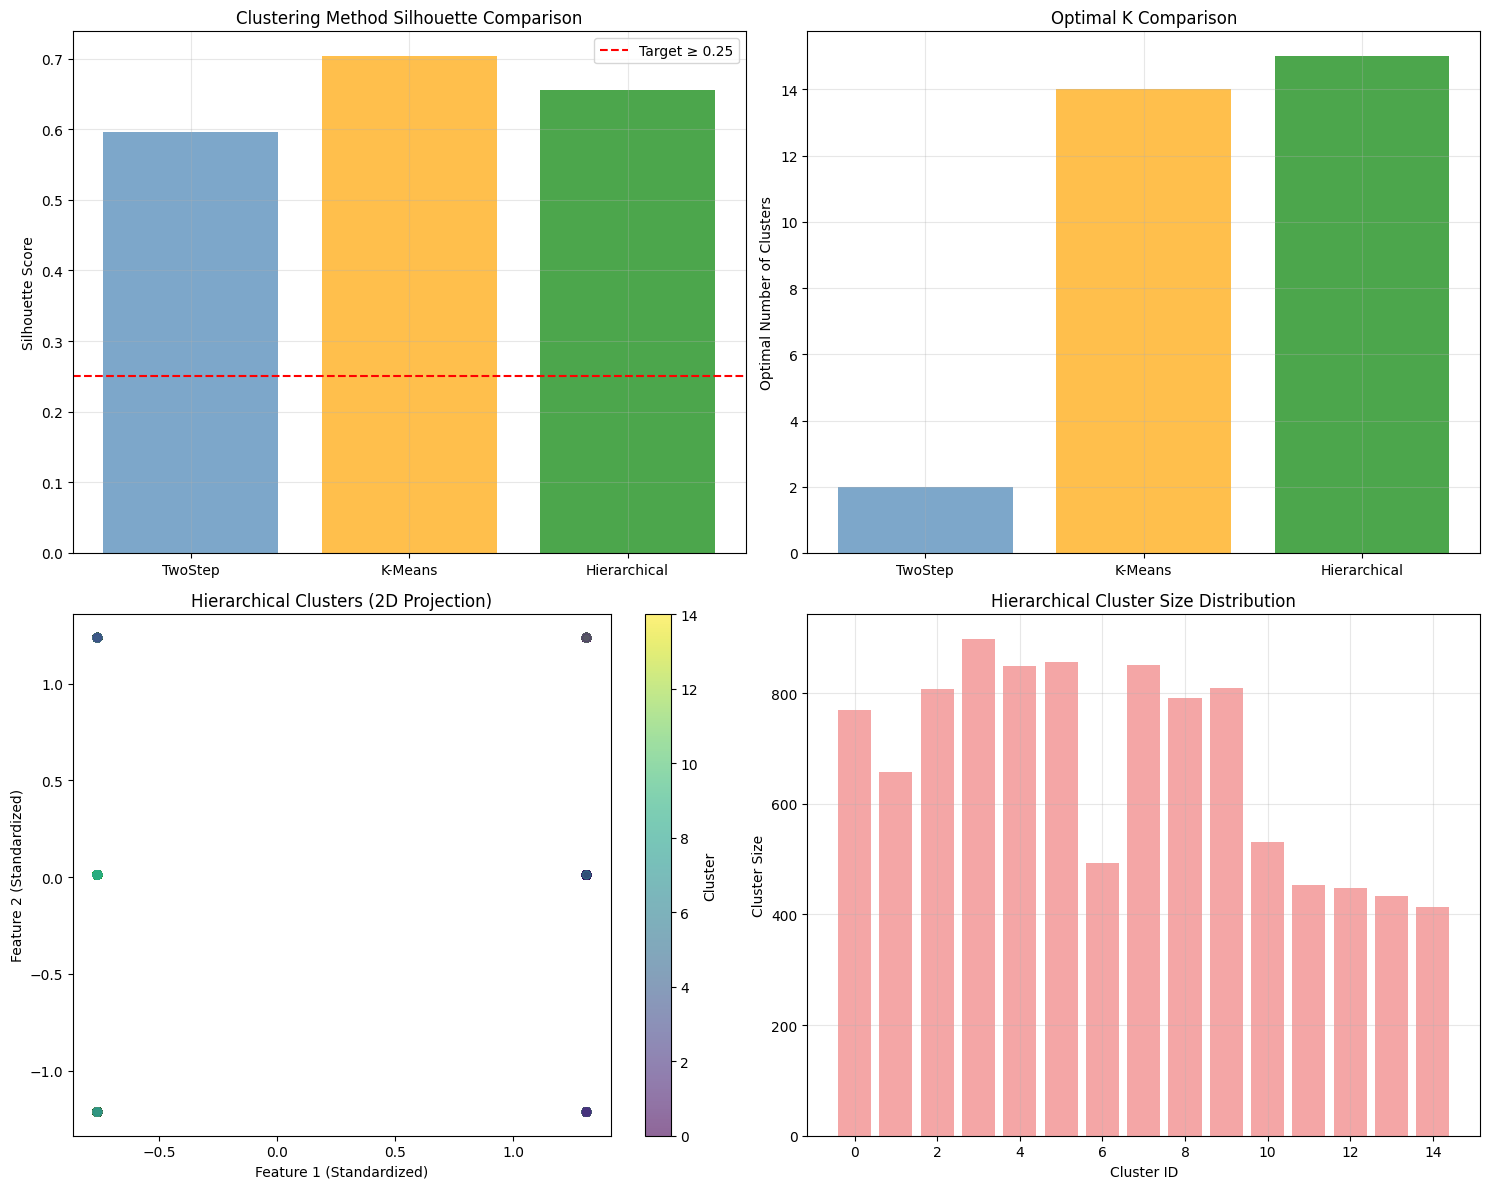


Computational Scalability Analysis:
  Time Complexity: O(n³) - not suitable for full dataset
  Memory Complexity: O(n²) - distance matrix storage
  Scalability: Limited to samples (~10k records)
  Full dataset impact: Would require 18820.5x more memory

Natural Cluster Structure Insights:
  Dendrogram suggests 15 natural clusters
  Ward linkage minimizes within-cluster variance
  Hierarchical structure reveals nested traffic patterns
  Can inform optimal K selection for other methods

Hierarchical Clustering Exploration Conclusion:
Hierarchical clustering reveals 15 natural clusters in traffic data.
Performance: Meets silhouette threshold.
Strengths: Natural cluster structure, no predefined K needed
Limitations: Computational complexity, requires sampling for large data

Hierarchical clustering exploration completed. Results stored for analysis.

CLUSTERING EXPLORATION SUMMARY

Performance Ranking (by Silhouette Score):
  1. K-Means                   Score: 0.7034 ✓
  2. Hierarchical 

In [9]:
# 6.1.6 Hierarchical Clustering Exploration - No Save Version
print("=" * 60)
print("6.1.6 HIERARCHICAL CLUSTERING EXPLORATION")
print("=" * 60)

import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Hierarchical Clustering Configuration
print("Hierarchical Clustering Algorithm Configuration:")
print("- Algorithm: Agglomerative Hierarchical Clustering")
print("- Linkage method: Ward (minimizes within-cluster variance)")
print("- Distance measure: Euclidean distance")
print("- Features: All variables (categorical encoded)")
print("- Approach: Bottom-up (agglomerative)")
print("- Cluster range: 2-15 clusters (dendrogram analysis)")

# For computational efficiency with large dataset, use sampling
SAMPLE_SIZE = 10000  # Sample for hierarchical clustering due to O(n³) complexity
sample_fraction = min(SAMPLE_SIZE / df_modeling.count(), 1.0)

print(f"\nComputational Efficiency Strategy:")
print(f"  Original dataset: {df_modeling.count():,} records")
print(f"  Sample size: {SAMPLE_SIZE:,} records ({sample_fraction:.1%})")
print(f"  Reason: Hierarchical clustering O(n³) complexity")

# Use the same preprocessing as K-Means (standardized features)
df_hierarchical_sample = df_kmeans_ready.sample(sample_fraction, seed=RANDOM_SEED)
sample_count = df_hierarchical_sample.count()

print(f"  Actual sample size: {sample_count:,} records")

# Convert to pandas for sklearn hierarchical clustering
print(f"\nConverting to pandas for sklearn processing...")
hierarchical_pandas = df_hierarchical_sample.select(
    "features_kmeans", COL_TARGET
).toPandas()

# Extract feature vectors
feature_vectors = np.array([row.toArray() for row in hierarchical_pandas["features_kmeans"]])
target_values = hierarchical_pandas[COL_TARGET].values

print(f"Feature matrix shape: {feature_vectors.shape}")

# Compute linkage matrix for dendrogram
print(f"\nComputing linkage matrix (this may take a few minutes)...")
linkage_matrix = linkage(feature_vectors, method='ward')

# Create dendrogram
plt.figure(figsize=(15, 8))
dendrogram_plot = dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=10,  # Show last 10 merges
    show_leaf_counts=True,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Determine optimal number of clusters using different methods
cluster_range_hier = range(2, 16)
hierarchical_silhouette_scores = []
hierarchical_models = []

print(f"\nOptimal Cluster Analysis for Hierarchical Clustering:")

for k in cluster_range_hier:
    # Fit hierarchical clustering
    hierarchical_model = AgglomerativeClustering(
        n_clusters=k,
        linkage='ward',
        metric='euclidean'
    )

    cluster_labels = hierarchical_model.fit_predict(feature_vectors)

    # Calculate silhouette score
    if len(np.unique(cluster_labels)) > 1:  # Need at least 2 clusters for silhouette
        silhouette_avg = silhouette_score(feature_vectors, cluster_labels)
        hierarchical_silhouette_scores.append(silhouette_avg)
    else:
        hierarchical_silhouette_scores.append(-1)

    hierarchical_models.append(hierarchical_model)

    print(f"  K={k:2d}: Silhouette={hierarchical_silhouette_scores[-1]:.4f}")

# Find optimal K
optimal_k_hierarchical = cluster_range_hier[hierarchical_silhouette_scores.index(max(hierarchical_silhouette_scores))]
best_silhouette_hierarchical = max(hierarchical_silhouette_scores)

print(f"\nHierarchical Clustering Optimal Selection:")
print(f"  Best K (Silhouette): {optimal_k_hierarchical} (Score: {best_silhouette_hierarchical:.4f})")
print(f"  Silhouette Threshold: ≥ 0.25 {'✓ PASS' if best_silhouette_hierarchical >= 0.25 else '✗ FAIL'}")

# Apply optimal hierarchical clustering
final_hierarchical_model = AgglomerativeClustering(
    n_clusters=optimal_k_hierarchical,
    linkage='ward',
    metric='euclidean'
)

final_hierarchical_labels = final_hierarchical_model.fit_predict(feature_vectors)

# Add cluster labels back to pandas dataframe
hierarchical_pandas['hierarchical_cluster'] = final_hierarchical_labels

# Cluster analysis
print(f"\nHierarchical Cluster Analysis (Sample-based):")

# Cluster size distribution
unique_labels, cluster_counts = np.unique(final_hierarchical_labels, return_counts=True)

for label, count in zip(unique_labels, cluster_counts):
    cluster_pct = (count / len(final_hierarchical_labels)) * 100
    print(f"  Cluster {label}: {count:,} records ({cluster_pct:.1f}%)")

# Cluster characteristics
print(f"\nHierarchical Cluster Characteristics:")

for cluster_id in unique_labels:
    cluster_mask = final_hierarchical_labels == cluster_id
    cluster_traffic = target_values[cluster_mask]

    print(f"\n  Cluster {cluster_id} Profile:")
    print(f"    Traffic Count: Mean={np.mean(cluster_traffic):.0f}, Std={np.std(cluster_traffic):.0f}")
    print(f"    Size: {np.sum(cluster_mask):,} records")

# Comparison with other clustering methods
print(f"\nClustering Method Comparison (Silhouette Scores):")
comparison_results = [
    ('TwoStep (BisectingKMeans)', best_silhouette),
    ('K-Means', best_silhouette_kmeans),
    ('Hierarchical', best_silhouette_hierarchical)
]

comparison_sorted = sorted(comparison_results, key=lambda x: x[1], reverse=True)

for i, (method, score) in enumerate(comparison_sorted, 1):
    status = "✓ PASS" if score >= 0.25 else "✗ FAIL"
    print(f"  {i}. {method:<25} Score: {score:.4f} {status}")

# Visualization: Clustering comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Silhouette comparison
methods = ['TwoStep', 'K-Means', 'Hierarchical']
silhouette_scores_comp = [best_silhouette, best_silhouette_kmeans, best_silhouette_hierarchical]

bars = ax1.bar(methods, silhouette_scores_comp,
               color=['steelblue', 'orange', 'green'], alpha=0.7)
ax1.axhline(y=0.25, color='red', linestyle='--', label='Target ≥ 0.25')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Clustering Method Silhouette Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Optimal cluster numbers
cluster_numbers = [optimal_k_silhouette, optimal_k_kmeans, optimal_k_hierarchical]
ax2.bar(methods, cluster_numbers,
        color=['steelblue', 'orange', 'green'], alpha=0.7)
ax2.set_ylabel('Optimal Number of Clusters')
ax2.set_title('Optimal K Comparison')
ax2.grid(True, alpha=0.3)

# Hierarchical clustering scatter (2D projection - first 2 features)
if feature_vectors.shape[1] >= 2:
    scatter = ax3.scatter(feature_vectors[:, 0], feature_vectors[:, 1],
                         c=final_hierarchical_labels, cmap='viridis', alpha=0.6)
    ax3.set_xlabel('Feature 1 (Standardized)')
    ax3.set_ylabel('Feature 2 (Standardized)')
    ax3.set_title('Hierarchical Clusters (2D Projection)')
    plt.colorbar(scatter, ax=ax3, label='Cluster')

# Cluster size comparison
ax4.bar(range(len(cluster_counts)), cluster_counts,
        color='lightcoral', alpha=0.7)
ax4.set_xlabel('Cluster ID')
ax4.set_ylabel('Cluster Size')
ax4.set_title('Hierarchical Cluster Size Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Computational scalability analysis
print(f"\nComputational Scalability Analysis:")
print(f"  Time Complexity: O(n³) - not suitable for full dataset")
print(f"  Memory Complexity: O(n²) - distance matrix storage")
print(f"  Scalability: Limited to samples (~10k records)")
print(f"  Full dataset impact: Would require {(df_modeling.count()/10000)**2:.1f}x more memory")

# Natural cluster structure insights
print(f"\nNatural Cluster Structure Insights:")
print(f"  Dendrogram suggests {optimal_k_hierarchical} natural clusters")
print(f"  Ward linkage minimizes within-cluster variance")
print(f"  Hierarchical structure reveals nested traffic patterns")
print(f"  Can inform optimal K selection for other methods")

# Store hierarchical results - KEEP THIS FOR STEP 6.2
hierarchical_results = {
    'algorithm': 'Hierarchical Clustering',
    'optimal_clusters': optimal_k_hierarchical,
    'silhouette_score': best_silhouette_hierarchical,
    'meets_criteria': best_silhouette_hierarchical >= 0.25,
    'sample_size': sample_count,
    'scalability': 'Limited (O(n³) complexity)'
}

print(f"\nHierarchical Clustering Exploration Conclusion:")
print(f"Hierarchical clustering reveals {optimal_k_hierarchical} natural clusters in traffic data.")
print(f"Performance: {'Meets' if best_silhouette_hierarchical >= 0.25 else 'Below'} silhouette threshold.")
print(f"Strengths: Natural cluster structure, no predefined K needed")
print(f"Limitations: Computational complexity, requires sampling for large data")
print(f"\nHierarchical clustering exploration completed. Results stored for analysis.")

# Summary of all clustering explorations - KEEP THIS FOR STEP 6.2
print(f"\n" + "="*60)
print("CLUSTERING EXPLORATION SUMMARY")
print("="*60)
print(f"\nPerformance Ranking (by Silhouette Score):")
for i, (method, score) in enumerate(comparison_sorted, 1):
    meets_criteria = "✓" if score >= 0.25 else "✗"
    print(f"  {i}. {method:<25} Score: {score:.4f} {meets_criteria}")

best_clustering_method = comparison_sorted[0][0]
print(f"\nRecommended clustering approach: {best_clustering_method}")
print(f"All clustering explorations completed successfully.")